In [1]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
load_dotenv()

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import (LinearRegression, RidgeCV, LassoCV, 
                                  GammaRegressor, HuberRegressor)

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit


sys.path.append('../')

from sqlalchemy import create_engine
from database.queries import get_game_stats

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', 100)

In [2]:
# loading up the postgres credentials
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
database = os.getenv('DB_NAME')
port = os.getenv('DB_PORT')

# # creating the URI for the database
URI = f'postgresql://{user}:{password}@{host}:{port}/{database}'

# establishing a connection to the database
engine = create_engine(URI)

In [3]:
# getting next gen stats. note that week 0 is total stats for each season
next_gen_query = """
    select *
    from next_gen_passing
    where week > 0
"""

ngp = pd.read_sql(next_gen_query, URI)
ngp.rename(columns={'player_gsis_id' : 'player_id'}, inplace=True)

In [4]:
lee_sharpe_query = """
    select *
    from lee_sharpe
    where season >= 2012
"""

ls = pd.read_sql(lee_sharpe_query, URI)

In [5]:
ls.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,2012_01_ATL_KC,2012,REG,1,2012-09-09,Sunday,13:00,ATL,40,KC,24,Home,-16,64,0,2012090908,55509.0,None,201209090kan,2391.0,320909012,7,7,-130.0,118.0,-1.0,-123.0,114.0,43.0,-104.0,-106.0,0,outdoors,grass,69.0,7.0,00-0026143,00-0023662,Matt Ryan,Matt Cassel,Mike Smith,Romeo Crennel,Mike Shepherd,KAN00,Arrowhead Stadium
1,2012_01_BUF_NYJ,2012,REG,1,2012-09-09,Sunday,13:00,BUF,28,NYJ,48,Home,20,76,0,2012090902,55512.0,None,201209090nyj,2392.0,320909020,7,7,130.0,-144.0,3.0,-109.0,101.0,39.5,100.0,-110.0,1,outdoors,fieldturf,74.0,1.0,00-0023682,00-0026898,Ryan Fitzpatrick,Mark Sanchez,Chan Gailey,Rex Ryan,Robert Frazer,NYC01,MetLife Stadium
2,2012_01_CAR_TB,2012,REG,1,2012-09-09,Sunday,16:25,CAR,10,TB,16,Home,6,26,0,2012090911,55516.0,None,201209090tam,2393.0,320909027,7,7,-161.0,145.0,-3.0,-106.0,-102.0,45.5,-106.0,-104.0,1,outdoors,grass,83.0,15.0,00-0027939,00-0026993,Cam Newton,Josh Freeman,Ron Rivera,Greg Schiano,Jerry Hughes,TAM00,Raymond James Stadium
3,2012_01_CIN_BAL,2012,REG,1,2012-09-10,Monday,19:00,CIN,13,BAL,44,Home,31,57,0,2012091000,55518.0,None,201209100rav,2404.0,320910033,7,7,281.0,-320.0,7.0,-102.0,-106.0,42.5,-110.0,100.0,1,outdoors,sportturf,74.0,10.0,00-0027973,00-0026158,Andy Dalton,Joe Flacco,Marvin Lewis,John Harbaugh,Matt Nicks,BAL00,M&T Bank Stadium
4,2012_01_DAL_NYG,2012,REG,1,2012-09-05,Wednesday,20:30,DAL,24,NYG,17,Home,-7,41,0,2012090500,55504.0,None,201209050nyg,2390.0,320905019,7,7,164.0,-182.0,3.5,-108.0,100.0,45.5,-103.0,-107.0,1,outdoors,fieldturf,77.0,5.0,00-0021678,00-0022803,Tony Romo,Eli Manning,Jason Garrett,Tom Coughlin,Jim Core,NYC01,MetLife Stadium


In [6]:
# changing the names in the Lee Sharpe dataframe to match the names in the 
# nflfastr dataframe. This will allow us to combine data more easily, 
# using game_id. 

lv_home_condition = (ls['home_team'] == 'OAK') & (ls['season'] < 2020)
lv_away_condition = (ls['away_team'] == 'OAK') & (ls['season'] < 2020)
ls.loc[lv_home_condition, 'home_team'] = 'LV'
ls.loc[lv_away_condition, 'away_team'] = 'LV'

la_home_condition = (ls['home_team'] == 'STL') & (ls['season'] < 2016)
la_away_condition = (ls['away_team'] == 'STL') & (ls['season'] < 2016)
ls.loc[la_home_condition, 'home_team'] = 'LA'
ls.loc[la_away_condition, 'away_team'] = 'LA'

lac_home_condition = (ls['home_team'] == 'SD') & (ls['season'] < 2017)
lac_away_condition = (ls['away_team'] == 'SD') & (ls['season'] < 2017)
ls.loc[lac_home_condition, 'home_team'] = 'LAC'
ls.loc[lac_away_condition, 'away_team'] = 'LAC'

In [7]:
query = """
    select *
    from player_stats
    where season >=2012 and position = 'QB'
    order by season asc, week asc
"""
df = pd.read_sql(query, con=engine)

In [8]:
# getting game ids by week from the lee sharpe data. starting with home then
# using update to get the away team game ids
game_id_dict = ls.set_index(['season', 'week', 'home_team'])['game_id'].to_dict()
ls_gameid_away = ls.set_index(['season', 'week', 'away_team'])['game_id'].to_dict()

game_id_dict.update(ls_gameid_away)

# assigning game ids to the player stats dataframe using the game id dictionary
df['game_id'] = 'NA'
df['game_id'] = [game_id_dict[(s, w, t)] if (s, w, t) in game_id_dict else 'NA' for s, w, t in zip(df.season, df.week, df.recent_team)]

print("there are now", df[df['game_id'] == 'NA'].shape[0], "missing game ids")

there are now 0 missing game ids


In [9]:
# merging the lee sharpe data with the player stats data
df = df.merge(ls, how='left', on=['game_id', 'season', 'week'], validate='many_to_one')

# getting total passing yards for qbs for each game -- will use this
# later
team_yards_dict = (
    df
    .groupby(['season', 'week', 'recent_team'])['passing_yards']
    .sum()
    .to_dict()
)

# limit the dataset to only quarterbacks who started the game
cond = (df['player_id'] == df['home_qb_id']) | (df['player_id'] == df['away_qb_id'])

starters = df[cond].copy()
starters.reset_index(drop=True, inplace=True)

# are there any missing game ids in lee sharpe
set(ls.game_id.unique()).difference(set(starters.game_id.unique()))

set()

In [10]:
# getting team yards for each game
starters['team_passing_yards'] = (
    starters
    .apply(lambda x: team_yards_dict[(x['season'], x['week'], x['recent_team'])], axis=1)
)

# calculating fraction of total team yards
starters['frac_team_yards'] = starters['passing_yards'] / starters['team_passing_yards']

# getting total game epa for qbs - excluding receiving obv
starters['total_epa'] = starters['passing_epa'] + starters['rushing_epa']

In [11]:
# merging our starters dataframe with the next gen stats
ngp_cols = ['season', 'week', 'player_id', 'avg_time_to_throw', 'avg_completed_air_yards',
            'avg_intended_air_yards', 'avg_air_yards_differential', 'aggressiveness', 
            'avg_air_yards_to_sticks', 'expected_completion_percentage', 
            'completion_percentage_above_expectation', 'avg_air_distance']

starters = (
    starters
    .merge(ngp[ngp_cols], how='left', on=['season', 'week', 'player_id'], validate='one_to_one')
)


In [12]:
def ewm_player_statistics(data=None, alpha=None, min_periods=None):
    "calcs an exponentially weighted avg for a stat given an alpha and min period"
    data_mean = data.shift().ewm(alpha=alpha, min_periods=min_periods).mean()    
    return data_mean

In [13]:
# creating exponentially weighted moving averages for important traditional QB statistics

starters['ewm_passing_yards'] = (
    starters
    .groupby('player_id')['passing_yards']
    .transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    .fillna(starters['passing_yards'].median())
    )

starters['ewm_passing_epa'] = (
    starters
    .groupby('player_id')['passing_epa']
    .transform(lambda x: x.shift().ewm(alpha=0.08, min_periods=1).mean())
    .fillna(starters['passing_epa'].median())
    )

starters['ewm_rushing_epa'] = (
    starters
    .groupby('player_id')['rushing_epa']
    .transform(lambda x: x.shift().ewm(alpha=0.0425, min_periods=1).mean())
    .fillna(starters['rushing_epa'].median())
)

starters['ewm_total_epa'] = (
    starters
    .groupby('player_id')['total_epa']
    .transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    .fillna(starters['total_epa'].median())
    )

starters['ewm_passing_attempts'] = (
    starters
    .groupby('player_id')['attempts']
    .transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    .fillna(starters['attempts'].median())
    )

starters['ewm_pass_completions'] = (
    starters
    .groupby('player_id')['completions']
    .transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    .fillna(starters['completions'].median())
)
    
starters['ewm_interceptions'] = (
    starters
    .groupby('player_id')['interceptions']
    .transform(lambda x: ewm_player_statistics(x, 0.13, 1))
    .fillna(starters['interceptions'].median())
)


# calculating some exponentially weighted ratios
starters['ewm_completion_perc'] = starters['ewm_pass_completions'].div(starters['ewm_passing_attempts'])
starters['ewm_epa_per_att'] = starters['ewm_passing_epa'].div(starters['ewm_passing_attempts'])
starters['ewm_py_per_att'] = starters['ewm_passing_yards'].div(starters['ewm_passing_attempts'])

In [14]:
# getting exponentially weighted moving averages for more advanced statistics
# ewm of intended air yards
starters['ewm_avg_intended_air_yards'] = (
    starters
    .groupby('player_id')['avg_intended_air_yards']
    .transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    .fillna(starters['avg_intended_air_yards'].median())
)

# ewm for completion percentage over expectation
starters['ewm_cpoe'] = (
    starters
    .groupby('player_id')['completion_percentage_above_expectation']
    .transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    .fillna(0)
)

# ewm for air yards on completions minus air yards intended
starters['ewm_ay_differential'] = (
    starters
    .groupby('player_id')['avg_air_yards_differential']
    .transform(lambda x: ewm_player_statistics(x, 0.08, 1))
    .fillna(starters['avg_air_yards_differential'].median())
)

Calculating an expanding league wide passing yards by  
week.  

In [15]:
# average passing yards by season, week
starters = starters[starters['season_type'] == 'REG'].copy()

passing_yards_sw = (
    starters
    .groupby(['season', 'week'])['passing_yards']
    .mean()
    .reset_index()
)

passing_yards_sw['season_expanding_mean'] = (
    passing_yards_sw
    .groupby('season')['passing_yards']
    .transform(lambda x: x.shift().expanding().mean())
    .fillna(method='ffill')
    .fillna(250)
)

py_sw = passing_yards_sw.set_index(['season', 'week'])['season_expanding_mean'].to_dict()

# adding the season expanding mean computed using weeks
# and the dictionary created above
starters['season_expanding_mean'] = (
    starters
    .apply(lambda row: py_sw[(row['season'], row['week'])], axis=1)
)

In [16]:
# counting games played - it'll be games played up until the row
# so 0 = first start
starters['games_started'] = starters.groupby('player_id').cumcount()

In [18]:
# creating adjusted statistics using mild shrinkage
shrinkage_constant = 3

# adding the shrinkage factor to the df
starters['shrinkage_factor'] = starters['games_started'] / (starters['games_started'] + shrinkage_constant)

# adjusting ewm passing yards
starters['adj_ewm_passing_yards'] = starters['shrinkage_factor'] * starters['ewm_passing_yards'] + \
                                    (1 - starters['shrinkage_factor']) * starters['season_expanding_mean']

# adjusting passing epa
starters['passing_epa_global_mean'] = starters['passing_epa'].shift().expanding().mean().fillna(0.05)
starters['adj_ewm_passing_epa'] = starters['shrinkage_factor'] * starters['ewm_passing_epa'] + \
                                  (1 - starters['shrinkage_factor']) * starters['passing_epa_global_mean']

# adjusting passing attempts
starters['passing_attempts_global_mean'] = starters['attempts'].shift().expanding().mean().fillna(40)
starters['adj_ewm_passing_attempts'] = starters['shrinkage_factor'] * starters['ewm_passing_attempts'] + \
                                       (1 - starters['shrinkage_factor']) * starters['passing_attempts_global_mean']


# calculating adjusted epa per attempt
starters['adj_ewm_epa_per_att'] = starters['adj_ewm_passing_epa'] / starters['adj_ewm_passing_attempts']

# calculating adjusted passing yards per attempt
starters['adj_ewm_py_per_att'] = starters['adj_ewm_passing_yards'].div(starters['adj_ewm_passing_attempts'])

In [19]:
# adjusting ewm rushing yards
starters['rushing_epa_global_mean'] = starters['rushing_epa'].shift().expanding().mean().fillna(-3.75)

starters['adj_ewm_rushing_epa'] = starters['shrinkage_factor'] * starters['ewm_rushing_epa'] + \
                                  (1 - starters['shrinkage_factor']) * starters['rushing_epa_global_mean']

In [115]:
# adjusting ewm total_epa. the optimal shrinkage for EPA is only 1. 
epa_shrinkage_constant = 1

starters['epa_shrinkage_factor'] = starters['games_started'] / (starters['games_started'] + epa_shrinkage_constant)

starters['total_epa_global_mean'] = starters['total_epa'].shift().expanding().mean().fillna(2)
starters['adj_ewm_total_epa'] = starters['epa_shrinkage_factor'] * starters['ewm_total_epa'] + \
                                  (1 - starters['epa_shrinkage_factor']) * starters['total_epa_global_mean']

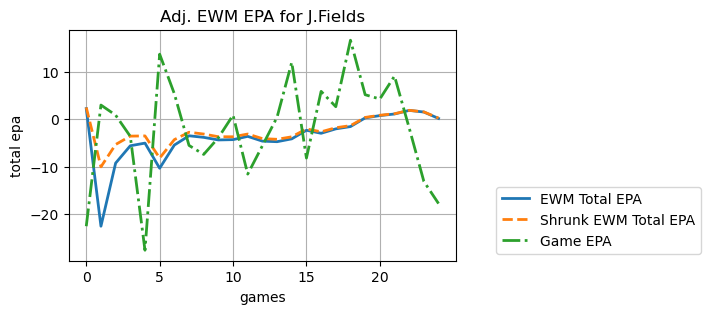

In [128]:
# plotting the effect of shrinkage for EPA
plot_shrinkage_epa = starters.query('player_name == "J.Fields"').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5,3))

plot_shrinkage_epa[['ewm_total_epa', 'adj_ewm_total_epa', 'total_epa']].plot(ax=ax, style=['-', '--', '-.'], linewidth=2.0)

plt.title(f"Adj. EWM EPA for {plot_shrinkage_epa['player_name'][0]}")
plt.xlabel('games')
plt.ylabel('total epa')
plt.legend([
    'EWM Total EPA', 
    'Shrunk EWM Total EPA', 
    'Game EPA'
], loc='lower right', bbox_to_anchor=(1.65, 0))

plt.xticks(np.arange(0, len(plot_shrinkage_epa), 5))

plt.grid(True)
plt.show()

In [21]:
# filling in nan values

starters['ewm_passing_attempts'].fillna(starters['ewm_passing_attempts'].median(), inplace=True)
starters['ewm_passing_yards'].fillna(starters['season_expanding_mean'], inplace=True)
starters['adj_ewm_passing_yards'].fillna(starters['adj_ewm_passing_yards'].median(), inplace=True)

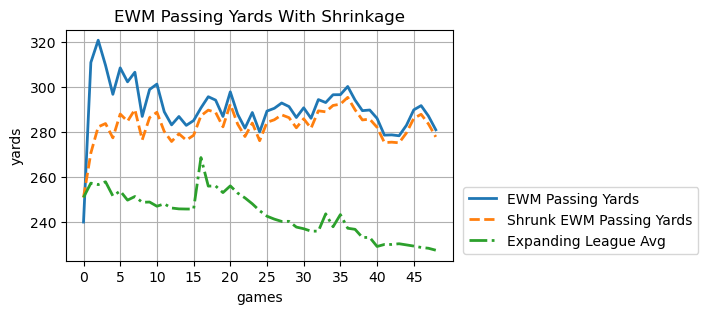

In [123]:
# plotting the effect of shrinkage. it keeps the first few 
# entries for each player close to the league average

plot_shrinkage = starters.query('player_name == "J.Herbert"').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5,3))

plot_shrinkage[['ewm_passing_yards', 'adj_ewm_passing_yards', 'season_expanding_mean']].plot(ax=ax, style=['-', '--', '-.'], linewidth=2.0)

plt.title('EWM Passing Yards With Shrinkage')
plt.xlabel('games')
plt.ylabel('yards')
plt.legend([
    'EWM Passing Yards', 
    'Shrunk EWM Passing Yards', 
    'Expanding League Avg'
], loc='lower right', bbox_to_anchor=(1.65, 0))

plt.xticks(np.arange(0, len(plot_shrinkage), 5))

plt.grid(True)
plt.show()

In [23]:
def calculate_trend(x):
    """
    local linear regression to find slope in performance
    """
    lr = LinearRegression()
    lr.fit(np.arange(len(x)).reshape(-1, 1), x)
    return lr.coef_[0]

In [25]:
# calculating the trend in performance over the last 20
# outings for each player

LOCAL_TREND_WINDOW = 25

starters['local_trend_ewm25'] = (
    starters
    .groupby('player_id')['adj_ewm_passing_yards']
    .transform(lambda x: x.rolling(LOCAL_TREND_WINDOW, min_periods=1).apply(calculate_trend))
)

In [26]:
# getting the team spread for each qb for each game
starters['team_spread'] = (
    starters
    .apply(lambda x: x['spread_line'] * -1 if x['recent_team'] == x['home_team'] else x['spread_line'], axis=1)
)


In [27]:
# getting the defensive team for each game and calculating 
# an exponentially weighted moving average for passing ep
# allowed - note, fix the neutral games!!!
starters['defteam'] = (
    starters
    .apply(lambda x: x['away_team'] if x['home_team'] == x['recent_team'] else x['away_team'], axis=1)
)

starters['defteam_ewm_passing_yards'] =(
    starters
    .groupby(['defteam'])['passing_yards']
    .transform(lambda x: x.shift().ewm(alpha=0.052, min_periods=1).mean())
    .fillna(starters['season_expanding_mean'])
)

# we should also apply shrinkage to defense - suboptimal implementation
def_shrinkage_constant = 7

starters['def_shrinkage_factor'] = starters['week'] / (starters['week'] + def_shrinkage_constant)
starters['adj_def_ewm_py'] = starters['def_shrinkage_factor'] * starters['defteam_ewm_passing_yards'] + \
                                  (1 - starters['def_shrinkage_factor']) * starters['season_expanding_mean']

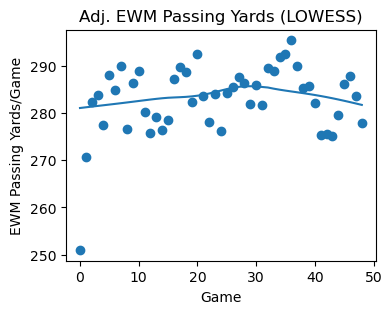

In [28]:
# plotting player passing yards over time using loess smoother
from statsmodels.nonparametric.smoothers_lowess import lowess

NAME = 'J.Herbert'
name_df = starters[starters['player_name'] == NAME].copy()

fig, ax = plt.subplots(figsize=(4,3))
lowess_smooth = lowess(name_df['adj_ewm_passing_yards'], np.arange(len(name_df)), frac=0.7)

plt.plot(lowess_smooth[:,0], lowess_smooth[:,1])
plt.scatter(np.arange(len(name_df)), name_df['adj_ewm_passing_yards'])
plt.title("Adj. EWM Passing Yards (LOWESS)")
plt.xlabel("Game")
plt.ylabel("EWM Passing Yards/Game")
plt.show()

In [105]:
from sklearn.metrics import mean_squared_error

test = starters.dropna(subset=['adj_ewm_total_epa', 'total_epa'])

mean_squared_error(test['total_epa'], test['adj_ewm_total_epa'], squared=False)

10.234643926680992

# Passing Yards Model  

We'll start by predicting the mean because it may be useful as part  
of other models, but ultimately we'll want to predict the median  
using a quantile regression in order to get numbers for  
over/unders

In [29]:
# limiting the model to only regular season games
starters = starters[starters['season_type'] == 'REG'].copy()

# limiting quarterbacks to those with more than 5 games

games_played = starters.groupby('player_id').size().reset_index(name='count')
more_than_5 = games_played[games_played['count'] >= 5]['player_id'].tolist()

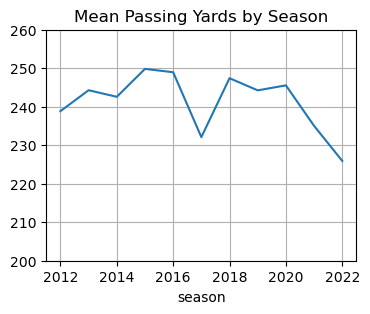

In [30]:
fig, ax = plt.subplots(figsize=(4,3))

starters.groupby('season')['passing_yards'].mean().plot()

plt.title("Mean Passing Yards by Season")
plt.ylim([200, 260])
plt.grid(True)
plt.show()

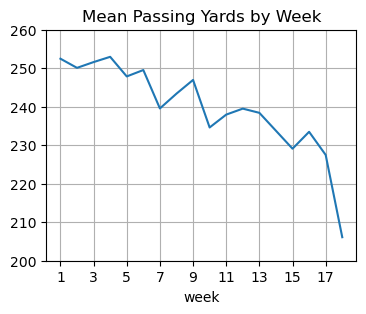

In [31]:
fig, ax = plt.subplots(figsize=(4,3))

starters.groupby('week')['passing_yards'].mean().plot()

plt.title("Mean Passing Yards by Week")
plt.ylim([200, 260])
plt.xticks(np.arange(1, 18, 2))
plt.grid(True)
plt.show()

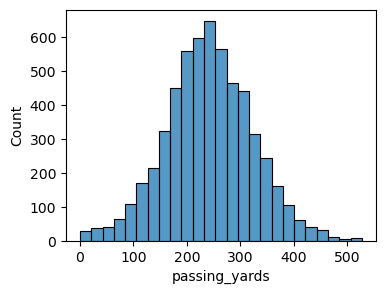

In [32]:
# now lets plot our target variable to see what the
# distribution looks like

fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(starters['passing_yards'], bins=25)
plt.show()

In [33]:
# the distribution above looks like it may not be normal
# i'll do a quick check to see if the normal or the gamma
# fit the data better. we'll use scipy.stats and the 
# kolmogorov-smirnoff test to measure distance from 
# the fitted distribution

from scipy import stats

mu, std = stats.norm.fit(starters['passing_yards'])
d, p = stats.kstest(starters['passing_yards'], 'norm', args=(mu, std))

s, loc, scale = stats.gamma.fit(starters['passing_yards'])
gamma_d, gamma_p = stats.kstest(starters['passing_yards'], 'gamma', args=(s, loc, scale))

print("gamma k-statistic and pval:", gamma_d, gamma_p)
print("norm k-statistic and pval:", d, p)

gamma k-statistic and pval: 0.01485719248408024 0.16130967432756615
norm k-statistic and pval: 0.016619854195375816 0.08583024260125582


They're close, but the gamma is a slightly better fit.  
I'll fit norma, gamma, and huber linear models and see which has  
best performance.

In [34]:
# restricting training to targets >0 - the gamma distribution
# is strictly positive

starters = starters[starters['passing_yards'] > 0].copy()

In [35]:
# creating an expanding weekly target mean (with a shift) 
# to see how it compares to treating each week as a 
# one hot encoded category
passing_yards_sw['expanding_week_avg'] = (
    passing_yards_sw
    .groupby('week')['passing_yards']
    .transform(lambda x: x.shift().expanding().mean())
)

# specifying a null condition (there will be 18, one for each week)
# and filling the null values with decreasing values
null_condition = passing_yards_sw['expanding_week_avg'].isnull()
passing_yards_sw.loc[null_condition, 'expanding_week_avg'] = np.linspace(250, 215, 18)

# creating a dictionary to add the values to the starters
# dataframe
season_week_avg = (
    passing_yards_sw
    .set_index(['season', 'week'])['expanding_week_avg']
    .to_dict()
)

# adding the values using the dictionary
starters['exp_week_avg'] = starters.apply(lambda x: season_week_avg[(x['season'], x['week'])], axis=1)

In [36]:
starters = starters[starters['season'] >= 2016].copy()

starters['max_yards'] = (
    starters.groupby('player_id')['passing_yards'].transform(lambda x: x.shift().expanding().max()).fillna(350)
)

In [37]:
# getting a baseline to compare our models against

print("the mae of just using the adj_ewm_passing_yards is:", 
      mean_absolute_error(starters['passing_yards'], starters['adj_ewm_passing_yards']))

the mae of just using the adj_ewm_passing_yards is: 60.62452117833752


In [80]:
features = ['adj_ewm_passing_yards', 'ewm_passing_attempts',
            'wind', 'passing_yards', 'temp', 'exp_week_avg', 
            'total_line', 'team_spread', 'adj_def_ewm_py', 
            'local_trend_ewm20', 'season_expanding_mean',
            'ewm_interceptions', 'adj_ewm_py_per_att']

model_df = starters[features].copy()
model_df['wind'] = model_df['wind'].fillna(0)
model_df['temp'] = model_df['temp'].fillna(72)
model_df['adj_def_ewm_py'] = np.log(model_df['adj_def_ewm_py'])
model_df.dropna(subset=['adj_ewm_passing_yards'], inplace=True)

numeric_cols = model_df.select_dtypes('number').columns

scaler = StandardScaler()
model = RidgeCV(alphas=[0.1, 1, 10, 100, 500, 1000])
gamma_model = GammaRegressor(alpha=0)
huber_model = HuberRegressor(alpha=5, max_iter=50, epsilon=1.15)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

pipeline_gamma = Pipeline([
    ('scaler', StandardScaler()),
    ('gamma_model', gamma_model)
])

pipeline_huber = Pipeline([
    ('scaler', StandardScaler()),
    ('huber_model', huber_model)
])

X = model_df.drop('passing_yards', axis=1)

y = model_df['passing_yards']

X_train, X_test = X.iloc[:3300].copy(), X.iloc[3300:].copy()
y_train, y_test = y.iloc[:3300].copy(), y.iloc[3300:].copy()

# ordinary model training
pipeline.fit(X_train, y_train)
pipeline_gamma.fit(X_train, y_train)
pipeline_huber.fit(X_train, y_train)

# the cross validation score calcs using time series
splitter = TimeSeriesSplit(n_splits=15)

ridge_scores = cross_val_score(pipeline, X, y, cv=splitter, scoring='neg_mean_absolute_error')
gamma_scores = cross_val_score(pipeline_gamma, X, y, cv=splitter, scoring='neg_mean_absolute_error')
huber_scores = cross_val_score(pipeline_huber, X, y, cv=splitter, scoring='neg_mean_absolute_error')

In [81]:
pipeline_huber.named_steps['huber_model'].coef_

array([ 8.02292248,  6.07628732, -6.10527481,  1.87388304,  1.93289367,
       13.83912206, -9.76431649,  2.9957081 , -0.07369064, -0.56834781,
       -2.86149948,  0.3058124 ])

In [82]:
# the cross validation scores with the time series split
score_comparison = (
    pd.DataFrame(ridge_scores, columns=['ridge'])
    .join(pd.DataFrame(gamma_scores, columns=['gamma']))
    .join(pd.DataFrame(huber_scores, columns=['huber']))
)

print("cross val score:")
print(score_comparison.mean() * -1)

cross val score:
ridge    58.990190
gamma    59.313779
huber    58.793528
dtype: float64


In [83]:
# creating a dataframe with the model params
model_params_df = pd.DataFrame({x:y for x, y in zip(X.columns, pipeline.named_steps['model'].coef_)}, index=[0])
model_params_df.insert(0, 'intercept', model.intercept_)

# how did this simple model do on the simple test set?
# it does beat the ewm for passing yards on its own
residuals = y_test - pipeline.predict(X_test)

print("the mean of the residuals is:", residuals.mean())

print("baseline MAE on test set using just the EWM:", 
     mean_absolute_error(y_test, starters[starters.index.isin(X_test.index)]['adj_ewm_passing_yards']).round(4))
print("huber MAE:", mean_absolute_error(y_test, pipeline_huber.predict(X_test)).round(4))
print("huber MSE:", mean_squared_error(y_test, pipeline_huber.predict(X_test)).round(4))

the mean of the residuals is: -3.8714107447374975
baseline MAE on test set using just the EWM: 57.4665
huber MAE: 55.4451
huber MSE: 5166.9345


We do alright on the test set when we train up to ~2021 and predict  
on the next few seasons, but we can easily improve upon this  
by retraining the model using all available data every week.  

It's worth noting that the residuals above suggest a systematic  
bias, which isn't surprising given how the passing yards per game  
were significantly lower 2020-2023.

We will do that below.

# Training Fresh Model Each Week  


In [41]:
# putting values into variables so we can both create dummies
# and then restore the values for later comparisons
weeks = starters['week'].values
seasons = starters['season'].values
players = starters['player_id'].values
starters['season_week'] = starters['season'].astype(str) + '_' + starters['week'].astype(str)
unique_weeks = starters['season_week'].unique()

starters = pd.get_dummies(starters, columns=['week', 'season', 'player_id']).copy()

In [42]:
numeric_columns = ['adj_ewm_passing_yards', 'adj_ewm_passing_attempts', 'wind', 'temp',
                   'total_line', 'team_spread', 'adj_def_ewm_py',
                   'local_trend_ewm20', 'ewm_interceptions', 'adj_ewm_py_per_att']

week_columns = [x for x in starters.columns if 'week_' in x]
season_columns = [x for x in starters.columns if 'season_2' in x]

feature_columns = numeric_columns + week_columns + season_columns

In [43]:
player_id_columns = [x for x in starters.columns if 'player_id_' in x]

feature_columns = feature_columns + player_id_columns

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNetCV

import warnings
warnings.filterwarnings("ignore")

In [45]:
starters['week'] = weeks
starters['season'] = seasons
starters['player_id'] = players
starters['preds'] = 0
starters['train_max'] = 'training'
starters['huber_preds'] = 0
starters['en_preds'] = 0

models = {}

for year_week in range(50, len(unique_weeks) - 1):
    
    season = int(unique_weeks[year_week].split('_')[0])
    week = int(unique_weeks[year_week].split('_')[1])
    condition = (starters['season'] <= season) & (starters['week'] <= week)
    
    df_ = starters[condition].copy()
    df_['wind'] = df_['wind'].fillna(0)
    df_['temp'] = df_['temp'].fillna(72)
    df_['week_squared'] = df_['week'] ** 2
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_columns)
        ], remainder='passthrough')
    
    model_ = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', RidgeCV(alphas=[10, 100, 200, 500, 1000]))])
    
    huber_model_ = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('huber_model', HuberRegressor(alpha=5, max_iter=50, epsilon=1.15))])
    
    
    elasticnet_model_ = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('elasticnet_model', ElasticNetCV(alphas=[0.1, 1, 10, 100], l1_ratio=[.1, .5, .7, .9, .95, .99, 1]))])
    
    
    X = df_.drop(columns='passing_yards')
    y = df_['passing_yards'].values
    
    model_.fit(X[feature_columns], y)
    models[year_week] = model_
    huber_model_.fit(X[feature_columns], y)
    elasticnet_model_.fit(X[feature_columns], y)
    
    # getting season and week so we can use a boolean mask for our prediction
    # dataframe
    pred_season = int(unique_weeks[year_week + 1].split('_')[0])
    pred_week = int(unique_weeks[year_week + 1].split('_')[1])
    pred_condition = (starters['season'] == pred_season) & (starters['week'] == pred_week)
    
    # using the mask and filling in nulls
    pred_df_ = starters[pred_condition].copy()
    pred_df_['wind'] = pred_df_['wind'].fillna(0)
    pred_df_['temp'] = pred_df_['temp'].fillna(72)
    pred_df_['week_squared'] = pred_df_['week'] ** 2
    
    # predicting on the next week
    preds = model_.predict(pred_df_[feature_columns])
    huber_preds = huber_model_.predict(pred_df_[feature_columns])
    en_preds = elasticnet_model_.predict(pred_df_[feature_columns])

    # adding the predictions to the main dataframe
    starters.loc[pred_condition, 'en_preds'] = en_preds
    starters.loc[pred_condition, 'huber_preds'] = huber_preds
    starters.loc[pred_condition, 'preds'] = preds
    starters.loc[pred_condition, 'train_max'] = unique_weeks[year_week]

In [92]:
# restricting the data to where we have out of fold predictions
no_zero = starters[starters['preds'] != 0].copy()
no_zero['residual'] = no_zero['preds'] - no_zero['passing_yards']
no_zero['huber_residual'] = no_zero['huber_preds'] - no_zero['passing_yards']

# no_zero = no_zero[no_zero.index.isin(X_test.index)].copy()

print('overall MSE of ridge models trained up to each week:',
      mean_squared_error(no_zero['passing_yards'], no_zero['preds'])
     )

print('overall MSE of huber models trained up to each week:',
      mean_squared_error(no_zero['passing_yards'], no_zero['huber_preds'])
     )

print('overall MSE of an adjusted EWM:',
      mean_squared_error(no_zero['passing_yards'], no_zero['adj_ewm_passing_yards'])
     )

print("average residuals ridge:", no_zero['residual'].mean())
print("average residuals huber:", no_zero['huber_residual'].mean())

overall MSE of ridge models trained up to each week: 5701.133908304855
overall MSE of huber models trained up to each week: 5652.108611221734
overall MSE of an adjusted EWM: 5980.41552751832
average residuals ridge: 8.896397608178425
average residuals huber: -0.35123385196869555


# Combining the Models  

Creating a linear ensemble of the three linear models  
I already have and training additional quantile models.  

In [47]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import QuantileRegressor

splitter = KFold(n_splits=8, shuffle=True, random_state=4416)

oof = np.zeros(len(no_zero))

oof_95 = np.zeros(len(no_zero))
oof_5 = np.zeros(len(no_zero))
oof_50 = np.zeros(len(no_zero))

X_ensemble = no_zero[['huber_preds', 'preds', 'en_preds']].copy().reset_index(drop=True)
y_ensemble = no_zero['passing_yards'].values


for train, val in splitter.split(X_ensemble, y_ensemble):
    
    train_x = X_ensemble.iloc[train]
    train_y = y_ensemble[train]
    
    val_x = X_ensemble.iloc[val]
    
    model_ = LinearRegression()
    model_.fit(train_x, train_y)
    
    q50_model_ = QuantileRegressor(quantile=0.5, solver='highs')
    q95_model_ = QuantileRegressor(quantile=0.95, solver="highs")
    q5_model_ = QuantileRegressor(quantile=0.05, solver="highs")
    
    q50_model_.fit(train_x, train_y)
    q95_model_.fit(train_x, train_y)
    q5_model_.fit(train_x, train_y)

    preds = model_.predict(val_x)
    q50_preds = q50_model_.predict(val_x)
    q95_preds = q95_model_.predict(val_x)
    q5_preds = q5_model_.predict(val_x)
    
    oof[val] = preds
    oof_50[val] = q50_preds
    oof_95[val] = q95_preds
    oof_5[val] = q5_preds

print("mse of ensemble:", mean_squared_error(y_ensemble, oof))
print("avg residuals of ensemble:", (y_ensemble - oof).mean())
print("what percentage of the y_values are above the quantile_50 predictions?",
      (oof_50 > y_ensemble).mean())

mse of ensemble: 5578.025738626726
avg residuals of ensemble: -0.02469691453602443
what percentage of the y_values are above the quantile_50 predictions? 0.4988112220637185


Creating a linear combination of the three linear models  
outperforms using any individual model. The residuals  
also drop to 0. 

The predicted median is also exceeded ~50.1%, which suggests  
excellent calibration.

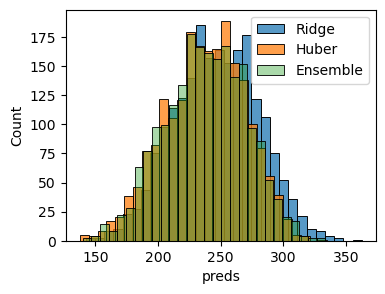

In [48]:
fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(no_zero['preds'], label='Ridge')
sns.histplot(no_zero['huber_preds'], label='Huber')
sns.histplot(oof, label='Ensemble', alpha=0.4)
plt.legend()
plt.show()

# Analyzing Over/Under  

Looking at over/under by decile, week, and whatever else comes to mind.

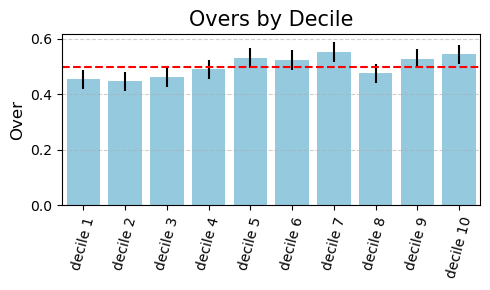

In [49]:
no_zero['q50'] = oof_50
no_zero['over'] = (no_zero['passing_yards'] > no_zero['q50']).astype(int)

decile_stats = no_zero.groupby(pd.qcut(no_zero['q50'], q=10))['over'].agg(['mean', 'sem'])
decile_stats.index = [f'decile {n+1}' for n in np.arange(len(decile_stats))]
decile_stats.reset_index(inplace=True)
decile_stats.columns = ['decile', 'coverage', 'standard_error']

plt.figure(figsize=(5, 3)) 

plt.title("Overs by Decile", fontsize=15)
sns.barplot(x='decile', y='coverage', yerr=decile_stats['standard_error'], data=decile_stats, color='skyblue') # Custom color
plt.axhline(0.5, linestyle='--', color='red')

plt.xticks(rotation=75, fontsize=10) 
plt.xlabel('') 
plt.ylabel('Over', fontsize=12) 

plt.grid(axis='y', linestyle='--', alpha=0.6) 

plt.tight_layout() 
plt.show()

Not loving this.

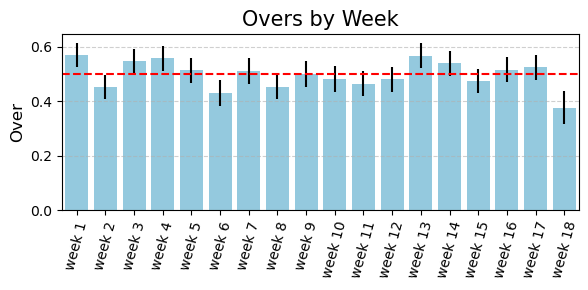

In [50]:
by_week = no_zero.groupby('week')['over'].agg(['mean', 'sem'])
by_week.index = [f'week {n+1}' for n in np.arange(len(by_week))]
by_week.reset_index(inplace=True)
by_week.columns = ['decile', 'coverage', 'standard_error']

plt.figure(figsize=(6, 3)) 

plt.title("Overs by Week", fontsize=15)
sns.barplot(x='decile', y='coverage', yerr=by_week['standard_error'], data=by_week, color='skyblue')
plt.axhline(0.5, linestyle='--', color='red')

plt.xticks(rotation=75, fontsize=10)
plt.xlabel('')
plt.ylabel('Over', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout() 
plt.show()

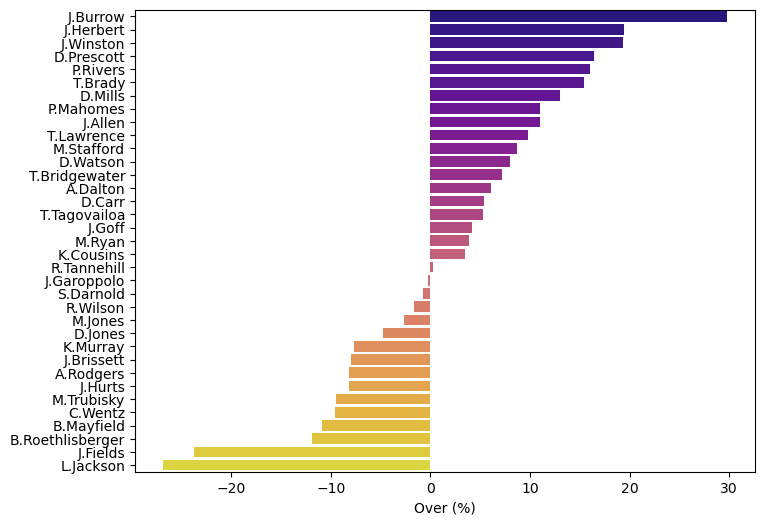

In [95]:
MIN_GAMES = 25

no_zero['over_ewm'] = (no_zero['passing_yards'] > no_zero['adj_ewm_passing_yards']).astype(int)

players_with_15_rows = no_zero['player_name'].value_counts() >= MIN_GAMES
player_names_to_keep = players_with_15_rows[players_with_15_rows].index
filtered_df = no_zero[no_zero['player_name'].isin(player_names_to_keep)]
player_overs = (
    filtered_df
    .groupby('player_name')['ensemble_residual']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(x='ensemble_residual', y='player_name', data=player_overs, orient='h', palette='plasma')

plt.ylabel('')
plt.xlabel('Over (%)')
plt.show()

# Quantile Coverage

In [94]:
# now we'll look at the other quantiles, mostly for fun.  
# i don't think there are any alt-lines for QB passing yards.  

no_zero['ensemble_preds'] = oof
no_zero['ensemble_residual'] = no_zero['passing_yards'] - no_zero['ensemble_preds']
no_zero['q95'] = oof_95
no_zero['q5'] = oof_5
no_zero['inside'] = np.where(no_zero['passing_yards'].between(no_zero['q5'], no_zero['q95']), 1, 0)

print("the oof coverage of our quantile regressors is:", no_zero['inside'].mean())

no_zero['width'] = no_zero['q95'] - no_zero['q5']

the oof coverage of our quantile regressors is: 0.9006181645268664


In [53]:
from scipy.stats import ttest_1samp

t, p = ttest_1samp(no_zero['huber_residual'], 0)
print("the t-statistic and p-value of the huber residuals are:", t, p)

t2, p2 = ttest_1samp(no_zero['ensemble_residual'], 0)
print("the t-statistic and p-value of the ensemble residuals are:", t2, p2)

the t-statistic and p-value of the huber residuals are: -0.2141964223659517 0.8304146614072155
the t-statistic and p-value of the ensemble residuals are: -0.015160684901744095 0.9879054257244709


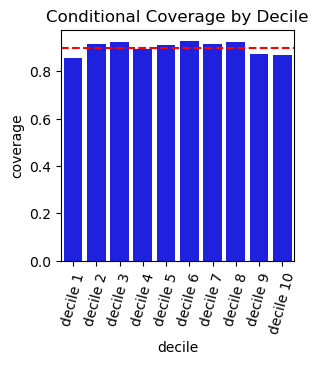

In [54]:
# plotting conditional coverage of the quantile models

r = no_zero.groupby(pd.qcut(no_zero['ensemble_preds'], q=10))['inside'].mean()
r.index = [f'decile {n+1}' for n in np.arange(len(r))]
r = r.reset_index()
r.columns = ['decile', 'coverage']

plt.figure(figsize=(3, 3))

plt.title("Conditional Coverage by Decile")
sns.barplot(x='decile', y='coverage', data=r, color='blue')
plt.axhline(0.9, linestyle='--', color='red')
plt.xticks(rotation=75)
plt.show()

# Manual Conformalized Quantile Regression  

We compute the residuals and adjust the interval for each of the predictions.  

The above quantile models already have excellent coverage, but  
as an exercise I'm going to compute the residuals with respect to the  
interval and conformalize the quantile predictions.  

Note that because all of the predictions are 'out of fold', they can all  
function as a calibration set.  

To better test the performance of the quantile models and the conformalized  
predictions we could do nested cross-validation, but in this particular instance  
I'm going to skip it. Maybe another football model will require it.  

In [55]:
def interval_residuals(intervals, values):
    "calculates the residuals for predictive intervals"
    left_resid = np.maximum(intervals[:,0]-values,0)
    right_resid = np.maximum(values-intervals[:,1],0)
    return(left_resid+right_resid)

In [56]:
# since we have out of fold predictions, we can calculate
# the interval residuals to create conformalized prediction
# intervals

intervals = np.array(no_zero[['q5', 'q95']])
actual = np.array(no_zero['passing_yards'])

residuals = interval_residuals(intervals, actual)
num_residuals = len(residuals)
qval = 1 - 0.10
idx_residual = int(np.ceil(qval * (num_residuals +1))-1)

conformal_adjustment = np.sort(residuals)[idx_residual]

print("the conformal adjustment would be:", conformal_adjustment.round(4))

the conformal adjustment would be: 0.0


In [57]:
# applying the conformal adjustment
no_zero['conformed_5'] = no_zero['q5'] - conformal_adjustment
no_zero['conformed_95'] = no_zero['q95'] + conformal_adjustment
no_zero['inside_conformed'] = (
    np.where(no_zero['passing_yards'].between(no_zero['conformed_5'], no_zero['conformed_95']),
             1,
             0)
)

print("conformalized coverage on the calibration set is:", no_zero['inside_conformed'].mean())

conformalized coverage on the calibration set is: 0.9006181645268664


Note that the coverage on the calibration set will of course by 90%.